In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
class Maximize(object):
    period = 30
    #np.random.seed(period)

    
    def __init__(self, n, rho, gamma):
        self.n = n
        self.rho = rho
        self.gamma = gamma
        
        
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.hc_ = self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_

        
    def get_original_H(self, hc_mu, hc_sigma):
        dc_rate = np.exp((0.04 + 0.0 + 0.0) * (np.array(range(self.period)) + 1) * (-1))
        
        if self.period == 0:
            self.labor_income = np.zeros([self.n, self.period+1])
            self.H_t = np.zeros([self.n])
        else:
            self.labor_income = self.initial_income*np.cumprod(np.exp(hc_mu+hc_sigma*(self.rho * self.market_[:, :-1] + np.sqrt(1 - self.rho ** 2) * self.hc_[:, :-1])), axis=1)
            self.H_t = self.labor_income @ dc_rate
    
    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income

In [3]:
class Maximize_Calibraton(object):
    period = 30
    #np.random.seed(period)
    retirement_age = 60

    
    def __init__(self, n, gamma, aggregate_risk, corr=None, rho=None):
        self.n = n
        self.corr = corr
        self.rho = rho
        self.gamma = gamma
        self.aggregate_risk = aggregate_risk
        
            
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.hc_ = self.aggregate_risk*(self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_)
        
        
    def MC_multi_data(self):
        self.brownian_ = np.random.multivariate_normal(np.zeros([self.corr.shape[0]]), self.corr, size=(self.n, self.period+2))
        self.market_ = self.brownian_[:, 0, 1:]
        self.hc_ = self.aggregate_risk*self.brownian_[:, :, :1].reshape(self.n, self.period+2)


    def get_calibration_H(self, fixed_effect_coeff, age_coeff_list):
        dc_rate = np.exp((0.04 + 0.0 + 0.0) * (np.array(range(self.period+1)) + 1) * (-1))
        age_list = np.array(list(range(self.retirement_age-(self.period+1), self.retirement_age)))

        after_retire_H_t = np.exp(fixed_effect_coeff) / (1-dc_rate[0])
        if self.period == 0:
            self.labor_income = np.exp(fixed_effect_coeff)
            self.H_t = after_retire_H_t
        else:
            ic_list = fixed_effect_coeff + (age_list * age_coeff_list[0]) + ((age_list**2 /10) * age_coeff_list[1]) + ((age_list**3/100) * age_coeff_list[2])
            self.labor_income = np.exp(np.array([ic_list]*self.n)  + self.hc_[:, :-1])
            self.H_t = self.labor_income @ dc_rate + (after_retire_H_t * dc_rate[-1])

    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
        
        
    def get_multiasset_ret(self, asset_data, freq_multiplyer=1):
        self.asset_mu = asset_data.mean().values * freq_multiplyer
        self.asset_std = asset_data.std().values * np.sqrt(freq_multiplyer)
        
        self.R_t = np.exp(np.ones(self.market_.shape)*self.asset_mu + (0.5*(np.ones(self.market_.shape)*self.asset_std)**2) + (self.asset_std*self.market_))
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income, retirement_age=60):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income
        self.retirement_age = retirement_age

In [4]:
def lc_asset_allocation(asset_dic, group_characherize_dic, sample_size=20000, gamma=4):
    np.random.seed(30)

    lc_weights = []
    lc_labor_income = []
    lc_wealth = []
    model = Maximize_Calibraton(n=sample_size, rho=group_characherize_data["rho"], gamma=gamma, aggregate_risk=group_characherize_data["aggregate_risk"])
    for i in range(35)[::-1]:

        if i is range(35)[::-1][0]:
            financial_wealth = group_characherize_data["initial_wealth"]
            income = group_characherize_data["initial_income"]
            model.change_parameters(i, financial_wealth, income)
        else:
            financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
            income = np.mean(model.labor_income[:, 0])
            model.change_parameters(i, financial_wealth, income)

        model.MC_data()
        model.get_calibration_H(fixed_effect_coeff=group_characherize_data["fixed_effect_coeff"], age_coeff_list=group_characherize_data["age_coeff_list"])
        model.get_asset_ret(market_mu=asset_data["risky"][0], market_sigma=asset_data["risky"][1], 
                            rf_mu=asset_data["rf"][0], rf_sigma=asset_data["rf"][1])
        opt_weights = model.fit()

        lc_weights.append(opt_weights)
        lc_labor_income.append(np.round(income))
        lc_wealth.append(np.round(financial_wealth))
        #print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))

        #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

    lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100
    lc_total_df = pd.DataFrame(np.array([lc_labor_income, lc_wealth]).T, index=range(35)[::-1], columns=["labor_income", "financial_wealth"])
    
    return lc_df, lc_total_df


def data_plotting(lc_total_df):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    ln1 = ax.plot(lc_total_df.index[::-1], lc_total_df.labor_income, color="b", label="labor_income")
    ax2 = ax.twinx()
    ln2 = ax2.plot(lc_total_df.index[::-1], lc_total_df.financial_wealth, color="r", linestyle="--", label="financial_wealth")

    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)

    plt.show()
    

def lc_weights_plot(lc_df):
    lc_df = lc_df.copy().cumsum(axis=1)
    
    plt.figure(figsize=(10, 5))
    
    plt.fill_between(lc_df.index, lc_df[lc_df.columns[0]])
    for i in range(lc_df.columns.shape[0]-1):
        plt.fill_between(lc_df.index, lc_df[lc_df.columns[i]], lc_df[lc_df.columns[i+1]])
    plt.legend(lc_df.columns)
    plt.ylim(0, 100)
    plt.show()

In [72]:
def lc_multiasset_allocation(asset_dic, group_characherize_dic, sample_size=20000, gamma=4, weight_constraint=False):
    np.random.seed(30)

    lc_weights = []
    lc_labor_income = []
    lc_wealth = []
    model = Maximize_Calibraton(n=sample_size, corr=group_characherize_data["corr_mat"], gamma=gamma, aggregate_risk=group_characherize_data["aggregate_risk"])
    for i in range(35)[::-1]:

        if i is range(35)[::-1][0]:
            financial_wealth = group_characherize_data["initial_wealth"]
            income = group_characherize_data["initial_income"]
            model.change_parameters(i, financial_wealth, income)
        else:
            financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
            income = np.mean(model.labor_income[:, 0])
            model.change_parameters(i, financial_wealth, income)

        model.MC_multi_data()
        model.get_calibration_H(fixed_effect_coeff=group_characherize_data["fixed_effect_coeff"], age_coeff_list=group_characherize_data["age_coeff_list"])
        model.get_multiasset_ret(asset_dic, freq_multiplyer=252)
        opt_weights = model.fit(weight_constraint=weight_constraint)

        lc_weights.append(opt_weights)
        lc_labor_income.append(np.round(income))
        lc_wealth.append(np.round(financial_wealth))
        #print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))

        #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

    lc_df = pd.DataFrame(lc_weights, columns=asset_dic.columns) * 100
    lc_total_df = pd.DataFrame(np.array([lc_labor_income, lc_wealth]).T, index=range(35)[::-1], columns=["labor_income", "financial_wealth"])
    
    return lc_df, lc_total_df

In [91]:
asset_data = {"risky": [0.12, 0.35], "rf":[0.04, 0.03]}

## High_school edu levels
_______________

In [92]:
group_characherize_data = {"rho":0.633465, "aggregate_risk":np.sqrt(0.174855+0.005461), 
                           "fixed_effect_coeff":[7.5072-0.7417+0.3198+0.059*2], "age_coeff_list":[0.0124, 0.0064, -0.0009], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.5072-0.7417+0.3198+0.059*2 + (25 * 0.0124 + ((25**2 /10) *0.0064) + ((25**3/100) * -0.0009)))}

In [97]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=6)

In [98]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2375.0,2595.0,2664.0,2752.0,2834.0,2889.0,2984.0,3066.0,3148.0,3223.0,...,4361.0,4408.0,4446.0,4444.0,4486.0,4496.0,4530.0,4509.0,4497.0,4508.0
financial_wealth,1000.0,2265.0,2481.0,2741.0,3027.0,3322.0,3703.0,4119.0,4599.0,5125.0,...,36054.0,40561.0,46182.0,52104.0,59334.0,67529.0,77006.0,87768.0,100128.0,115197.0


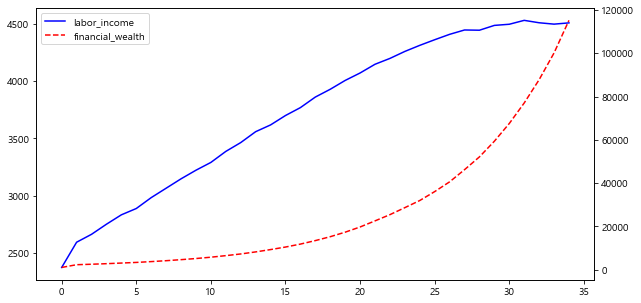

In [99]:
data_plotting(lc_data)

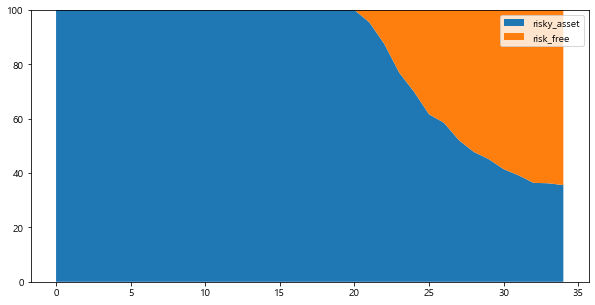

In [100]:
lc_weights_plot(lc_weights)

## College edu levels
_______________

In [12]:
group_characherize_data = {"rho":0.334903, "aggregate_risk":np.sqrt(0.145682+0.010166), 
                           "fixed_effect_coeff":[7.8016-2.3326+0.2550+0.0537*2], "age_coeff_list":[0.1232, -0.0193, 0.0011], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8016-2.3326+0.2550+0.0537*2 + (25 * 0.1232 + ((25**2 /10) * -0.0193) + ((25**3/100) * 0.0011)))}

In [13]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [14]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2636.0,2845.0,2977.0,3126.0,3267.0,3377.0,3527.0,3659.0,3787.0,3908.0,...,5473.0,5555.0,5624.0,5657.0,5729.0,5800.0,5888.0,5930.0,5978.0,6065.0
financial_wealth,1000.0,2361.0,4141.0,6482.0,9526.0,13386.0,18403.0,24845.0,33151.0,43697.0,...,745413.0,853188.0,978607.0,1118017.0,1278524.0,1460942.0,1669747.0,1904867.0,2169679.0,2487436.0


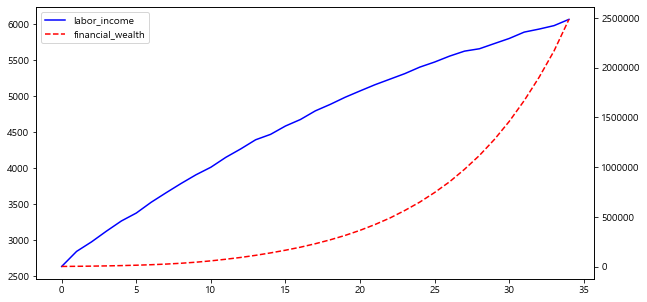

In [15]:
data_plotting(lc_data)

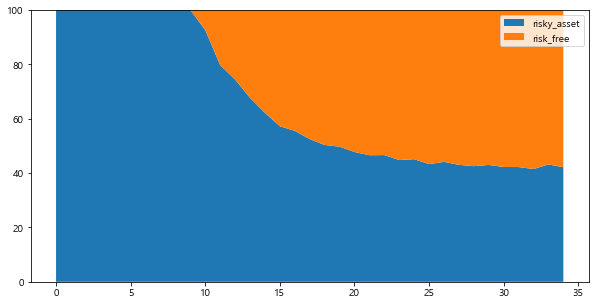

In [16]:
lc_weights_plot(lc_weights)

## University edu levels
_______________

In [17]:
group_characherize_data = {"rho":-0.010961, "aggregate_risk":np.sqrt(0.141262+0.005379), 
                           "fixed_effect_coeff":[7.8717-2.3055+0.3841+0.0440*2], "age_coeff_list":[0.1055, -0.0111, 0.0001], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8717-2.3055+0.3841+0.0440*2 + (25 * 0.1055 + ((25**2 /10) * -0.0111) + ((25**3/100) * 0.0001)))}

In [18]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [19]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3195.0,3358.0,3541.0,3719.0,3866.0,4054.0,4225.0,4390.0,4550.0,...,6212.0,6249.0,6250.0,6216.0,6191.0,6177.0,6154.0,6091.0,6008.0,5950.0
financial_wealth,1000.0,2494.0,4457.0,7044.0,10417.0,14705.0,20284.0,27458.0,36716.0,48480.0,...,854210.0,977894.0,1121739.0,1281653.0,1465794.0,1675075.0,1914478.0,2184127.0,2487930.0,2852432.0


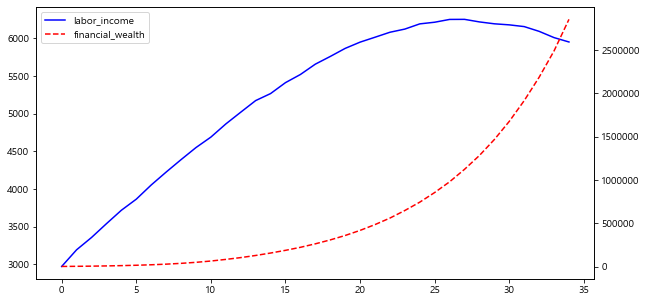

In [20]:
data_plotting(lc_data)

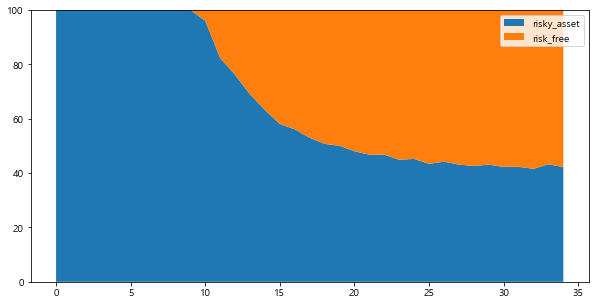

In [21]:
lc_weights_plot(lc_weights)

In [22]:
asset_data = pd.read_excel("C:\\Users\\JeayongYu\\PycharmProjects\\human_captial\\data\\korea_industry_return_daily.xlsx", index_col=0) / 100
corr_mat = pd.read_excel("C:\\Users\\JeayongYu\\PycharmProjects\\human_captial\\data\\university_corr.xlsx", index_col=0)

In [23]:
group_characherize_data = {"corr_mat":corr_mat.values, "aggregate_risk":np.sqrt(0.141262+0.005379), 
                           "fixed_effect_coeff":[7.8717-2.3055+0.3841+0.0440*2], "age_coeff_list":[0.1055, -0.0111, 0.0001], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8717-2.3055+0.3841+0.0440*2 + (25 * 0.1055 + ((25**2 /10) * -0.0111) + ((25**3/100) * 0.0001)))}

In [24]:
lc_weights, lc_data = lc_multiasset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [25]:
lc_weights = lc_weights[(lc_weights != 0)].dropna(axis=1, how="all").fillna(0)

In [26]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3198.0,3354.0,3543.0,3705.0,3860.0,4054.0,4204.0,4386.0,4528.0,...,6225.0,6251.0,6200.0,6238.0,6217.0,6201.0,6124.0,6099.0,5998.0,5934.0
financial_wealth,1000.0,2585.0,4732.0,7673.0,11576.0,16828.0,23770.0,32662.0,44478.0,59837.0,...,3687087.0,4732486.0,6060598.0,7749298.0,9932147.0,12718305.0,16261748.0,20881244.0,26614552.0,34175748.0


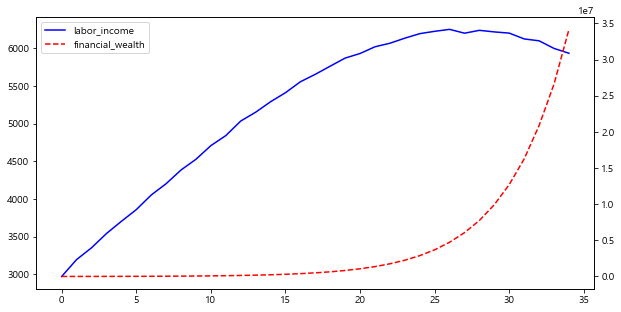

In [27]:
data_plotting(lc_data)

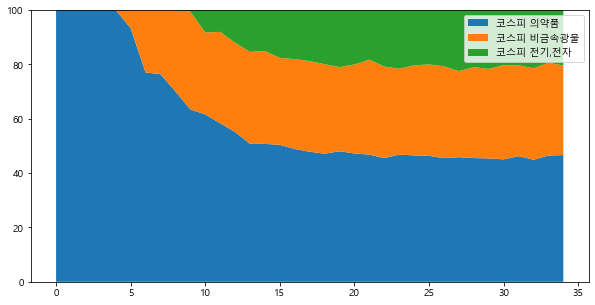

In [28]:
lc_weights_plot(lc_weights)

In [29]:
model = Maximize_Calibraton(n=20000, corr=group_characherize_data["corr_mat"], gamma=4, aggregate_risk=group_characherize_data["aggregate_risk"])

In [30]:
model.MC_multi_data()
model.get_calibration_H(fixed_effect_coeff=group_characherize_data["fixed_effect_coeff"], age_coeff_list=group_characherize_data["age_coeff_list"])
model.get_multiasset_ret(asset_data, freq_multiplyer=252)

In [31]:
np.mean(pd.DataFrame(model.R_t, columns=asset_data.columns) -1)

코스피 음식료품           0.111505
코스피 섬유,의복          0.171038
코스피 종이,목재          0.120369
코스피 화학             0.128870
코스피 의약품            0.316538
코스피 비금속광물          0.263126
코스피 철강및금속          0.044293
코스피 기계             0.064797
코스피 전기,전자          0.222473
코스피 운수장비           0.094156
코스피 유통업            0.049212
코스피 건설업            0.105951
코스피 운수창고           0.071390
코스피 금융업            0.052088
코스피 은행             0.082675
코스피 증권             0.110505
코스피 보험             0.033834
코스피 제조업            0.121251
국고채 총수익 지수         0.036841
국고채 콜 재투자 지수       0.035786
국고채 제로 재투자 지수      0.034758
KRW Cash 총수익 지수    0.024448
dtype: float64

In [36]:
pd.DataFrame(model.asset_std, index=asset_data.columns)

,0
코스피 음식료품,0.180454
"코스피 섬유,의복",0.237132
"코스피 종이,목재",0.211960
코스피 화학,0.218809
코스피 의약품,0.274517
코스피 비금속광물,0.248815
코스피 철강및금속,0.234281
코스피 기계,0.237309
"코스피 전기,전자",0.242340
코스피 운수장비,0.249688


In [32]:
model.asset_mu

array([ 0.07433517,  0.10129241,  0.06887034,  0.07338897,  0.20079862,
        0.17215172, -0.01202069,  0.00660414,  0.14364966,  0.02764276,
        0.01613379,  0.02028552,  0.01430897,  0.01470483,  0.01344966,
        0.02467862, -0.0051269 ,  0.08286069,  0.03581103,  0.03482621,
        0.03383172,  0.02414759])

In [76]:
class Maximize_Calibraton(object):
    period = 30
    #np.random.seed(period)
    retirement_age = 60

    
    def __init__(self, n, gamma, aggregate_risk, corr=None, rho=None):
        self.n = n
        self.corr = corr
        self.rho = rho
        self.gamma = gamma
        self.aggregate_risk = aggregate_risk
        
            
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.hc_ = self.aggregate_risk*(self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_)
        
        
    def MC_multi_data(self):
        self.brownian_ = np.random.multivariate_normal(np.zeros([self.corr.shape[0]]), self.corr, size=(self.n, self.period+2))
        self.market_ = self.brownian_[:, 0, 1:]
        self.hc_ = self.aggregate_risk*self.brownian_[:, :, :1].reshape(self.n, self.period+2)


    def get_calibration_H(self, fixed_effect_coeff, age_coeff_list):
        dc_rate = np.exp((0.04 + 0.0 + 0.0) * (np.array(range(self.period+1)) + 1) * (-1))
        age_list = np.array(list(range(self.retirement_age-(self.period+1), self.retirement_age)))

        after_retire_H_t = np.exp(fixed_effect_coeff) / (1-dc_rate[0])
        if self.period == 0:
            self.labor_income = np.exp(fixed_effect_coeff)
            self.H_t = after_retire_H_t
        else:
            ic_list = fixed_effect_coeff + (age_list * age_coeff_list[0]) + ((age_list**2 /10) * age_coeff_list[1]) + ((age_list**3/100) * age_coeff_list[2])
            self.labor_income = np.exp(np.array([ic_list]*self.n)  + self.hc_[:, :-1])
            self.H_t = self.labor_income @ dc_rate + (after_retire_H_t * dc_rate[-1])

    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
        
        
    def get_multiasset_ret(self, asset_data, freq_multiplyer=1):
        self.asset_mu = asset_data.mean().values * freq_multiplyer
        self.asset_mu[:-4] = self.asset_mu[:-4] / 2
        self.asset_std = asset_data.std().values * np.sqrt(freq_multiplyer)
        
        self.R_t = np.exp(np.ones(self.market_.shape)*self.asset_mu + (0.5*(np.ones(self.market_.shape)*self.asset_std)**2) + (self.asset_std*self.market_))
    
    
    def fit(self, weight_constraint=False):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        if weight_constraint is False:
            cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                    {'type': 'ineq', 'fun': lambda x: x},)
        else:
            cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                    {'type': 'ineq', 'fun': lambda x: x},
                    {'type': 'ineq', 'fun': lambda x: 0.25 - x},)
        
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income, retirement_age=60):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income
        self.retirement_age = retirement_age

In [80]:
asset_data = pd.read_excel("C:\\Users\\JeayongYu\\PycharmProjects\\human_captial\\data\\korea_industry_return_daily.xlsx", index_col=0) / 100
corr_mat = pd.read_excel("C:\\Users\\JeayongYu\\PycharmProjects\\human_captial\\data\\university_corr.xlsx", index_col=0)

In [56]:
group_characherize_data = {"corr_mat":corr_mat.values, "aggregate_risk":np.sqrt(0.141262+0.005379), 
                           "fixed_effect_coeff":[7.8717-2.3055+0.3841+0.0440*2], "age_coeff_list":[0.1055, -0.0111, 0.0001], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8717-2.3055+0.3841+0.0440*2 + (25 * 0.1055 + ((25**2 /10) * -0.0111) + ((25**3/100) * 0.0001)))}

In [57]:
lc_weights, lc_data = lc_multiasset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [58]:
lc_weights = lc_weights[(lc_weights != 0)].dropna(axis=1, how="all").fillna(0)

In [59]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3198.0,3354.0,3543.0,3705.0,3860.0,4054.0,4204.0,4386.0,4528.0,...,6225.0,6251.0,6200.0,6238.0,6217.0,6201.0,6124.0,6099.0,5998.0,5934.0
financial_wealth,1000.0,2338.0,3986.0,6046.0,8531.0,11561.0,15216.0,19483.0,24697.0,30869.0,...,498623.0,578971.0,668679.0,770230.0,887474.0,1022440.0,1171960.0,1348635.0,1536859.0,1770948.0


In [83]:
asset_data.corr()

,코스피 음식료품,"코스피 섬유,의복","코스피 종이,목재",코스피 화학,코스피 의약품,코스피 비금속광물,코스피 철강및금속,코스피 기계,"코스피 전기,전자",코스피 운수장비,...,코스피 운수창고,코스피 금융업,코스피 은행,코스피 증권,코스피 보험,코스피 제조업,국고채 총수익 지수,국고채 콜 재투자 지수,국고채 제로 재투자 지수,KRW Cash 총수익 지수
코스피 음식료품,1.000000,0.422353,0.442991,0.463143,0.420130,0.388483,0.333945,0.398644,0.215358,0.290607,...,0.411080,0.456174,0.321376,0.410933,0.353021,0.420161,-0.015518,-0.017247,-0.017320,-0.024831
"코스피 섬유,의복",0.422353,1.000000,0.456356,0.450288,0.312832,0.398283,0.340074,0.436080,0.257221,0.318253,...,0.412696,0.390902,0.281448,0.387292,0.269645,0.439347,-0.036256,-0.035634,-0.035819,0.006977
"코스피 종이,목재",0.442991,0.456356,1.000000,0.489266,0.389615,0.494899,0.403080,0.519168,0.336038,0.339415,...,0.455310,0.427653,0.314630,0.493500,0.259509,0.499048,-0.028135,-0.027929,-0.027968,-0.009950
코스피 화학,0.463143,0.450288,0.489266,1.000000,0.399556,0.455873,0.619106,0.626103,0.453966,0.600121,...,0.533617,0.606270,0.431029,0.633869,0.378539,0.786838,-0.128212,-0.129630,-0.129296,-0.080501
코스피 의약품,0.420130,0.312832,0.389615,0.399556,1.000000,0.282955,0.242025,0.329118,0.209124,0.207640,...,0.311954,0.295731,0.190112,0.352548,0.207196,0.407994,-0.057849,-0.058249,-0.057817,-0.008713
코스피 비금속광물,0.388483,0.398283,0.494899,0.455873,0.282955,1.000000,0.441814,0.503273,0.230691,0.288286,...,0.412620,0.393106,0.264817,0.424865,0.263969,0.411593,-0.030317,-0.030048,-0.029626,0.005962
코스피 철강및금속,0.333945,0.340074,0.403080,0.619106,0.242025,0.441814,1.000000,0.573128,0.403932,0.519257,...,0.477115,0.604952,0.469733,0.587250,0.405842,0.649331,-0.132762,-0.133500,-0.133247,-0.093627
코스피 기계,0.398644,0.436080,0.519168,0.626103,0.329118,0.503273,0.573128,1.000000,0.388459,0.569282,...,0.544225,0.558865,0.414491,0.584795,0.347466,0.644878,-0.123446,-0.124965,-0.124204,-0.053083
"코스피 전기,전자",0.215358,0.257221,0.336038,0.453966,0.209124,0.230691,0.403932,0.388459,1.000000,0.395579,...,0.350605,0.472341,0.336861,0.495378,0.290585,0.851186,-0.126063,-0.129001,-0.128904,-0.087601
코스피 운수장비,0.290607,0.318253,0.339415,0.600121,0.207640,0.288286,0.519257,0.569282,0.395579,1.000000,...,0.508895,0.552200,0.427166,0.502140,0.377287,0.716147,-0.124515,-0.125181,-0.124559,-0.089202


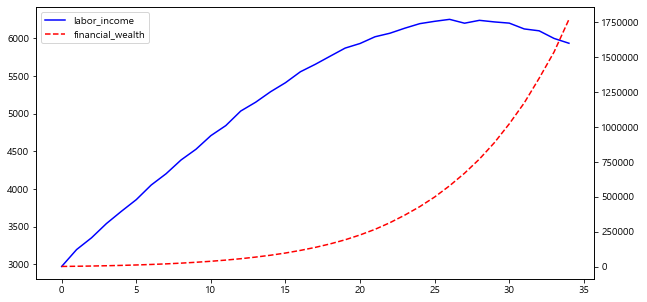

In [60]:
data_plotting(lc_data)

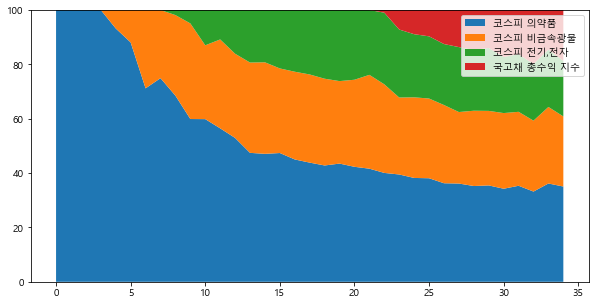

In [61]:
lc_weights_plot(lc_weights)

In [62]:
model = Maximize_Calibraton(n=20000, corr=group_characherize_data["corr_mat"], gamma=4, aggregate_risk=group_characherize_data["aggregate_risk"])

model.MC_multi_data()
model.get_calibration_H(fixed_effect_coeff=group_characherize_data["fixed_effect_coeff"], age_coeff_list=group_characherize_data["age_coeff_list"])
model.get_multiasset_ret(asset_data, freq_multiplyer=252)

np.mean(pd.DataFrame(model.R_t, columns=asset_data.columns) -1)

코스피 음식료품           0.070951
코스피 섬유,의복          0.113206
코스피 종이,목재          0.082446
코스피 화학             0.088198
코스피 의약품            0.190777
코스피 비금속광물          0.158949
코스피 철강및금속          0.050588
코스피 기계             0.061287
코스피 전기,전자          0.137748
코스피 운수장비           0.079138
코스피 유통업            0.040782
코스피 건설업            0.094790
코스피 운수창고           0.063752
코스피 금융업            0.044381
코스피 은행             0.075418
코스피 증권             0.096887
코스피 보험             0.036487
코스피 제조업            0.075746
국고채 총수익 지수         0.036841
국고채 콜 재투자 지수       0.035786
국고채 제로 재투자 지수      0.034758
KRW Cash 총수익 지수    0.024448
dtype: float64

In [65]:
asset_mustd = pd.concat([pd.DataFrame(model.asset_mu, index=asset_data.columns), pd.DataFrame(model.asset_std, index=asset_data.columns)], axis=1)
asset_mustd.columns =  ["mu", "sigma"]
asset_mustd

,mu,sigma
코스피 음식료품,0.037168,0.180454
"코스피 섬유,의복",0.050646,0.237132
"코스피 종이,목재",0.034435,0.211960
코스피 화학,0.036694,0.218809
코스피 의약품,0.100399,0.274517
코스피 비금속광물,0.086076,0.248815
코스피 철강및금속,-0.006010,0.234281
코스피 기계,0.003302,0.237309
"코스피 전기,전자",0.071825,0.242340
코스피 운수장비,0.013821,0.249688


In [66]:
lc_weights, lc_data = lc_multiasset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=6)
lc_weights = lc_weights[(lc_weights != 0)].dropna(axis=1, how="all").fillna(0)

lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3198.0,3354.0,3543.0,3705.0,3860.0,4054.0,4204.0,4386.0,4528.0,...,6225.0,6251.0,6200.0,6238.0,6217.0,6201.0,6124.0,6099.0,5998.0,5934.0
financial_wealth,1000.0,2338.0,3986.0,6046.0,8513.0,11481.0,15049.0,19239.0,24273.0,30173.0,...,378822.0,426777.0,478683.0,535879.0,599838.0,671118.0,747877.0,835585.0,926911.0,1035970.0


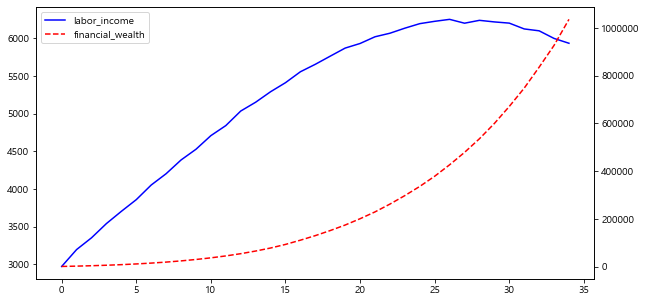

In [67]:
data_plotting(lc_data)

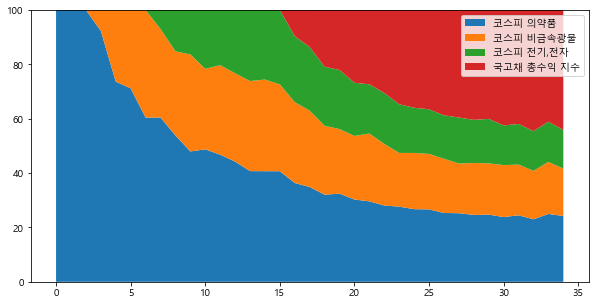

In [68]:
lc_weights_plot(lc_weights)

In [69]:
lc_data

,labor_income,financial_wealth
34,2974.0,1000.0
33,3198.0,2338.0
32,3354.0,3986.0
31,3543.0,6046.0
30,3705.0,8513.0
29,3860.0,11481.0
28,4054.0,15049.0
27,4204.0,19239.0
26,4386.0,24273.0
25,4528.0,30173.0


In [77]:
lc_weights, lc_data = lc_multiasset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=6, weight_constraint=True)
lc_weights = lc_weights[(lc_weights != 0)].dropna(axis=1, how="all").fillna(0)

lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3198.0,3354.0,3543.0,3705.0,3860.0,4054.0,4204.0,4386.0,4528.0,...,6225.0,6251.0,6200.0,6238.0,6217.0,6201.0,6124.0,6099.0,5998.0,5934.0
financial_wealth,1000.0,2338.0,3986.0,6046.0,8513.0,11481.0,15049.0,19239.0,24273.0,30173.0,...,378822.0,426777.0,478683.0,535879.0,599838.0,671118.0,747877.0,835585.0,926911.0,1035970.0


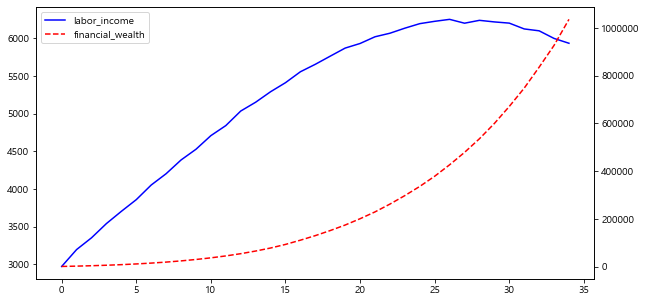

In [78]:
data_plotting(lc_data)

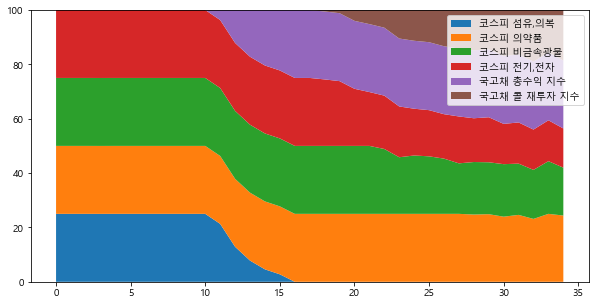

In [79]:
lc_weights_plot(lc_weights)